In [9]:
import torch
import torch.nn as nn
from flows import PlanarFlow
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.optim as optim
import numpy as np
from NormVAE import FlowVAE, BernoulliDecoder, LogitNormalDecoder

In [10]:
def prepare_dataset(dataset_name, batch_size, train=True):
    data = {
        'mnist': datasets.MNIST('datasets', train=train, download=True, transform=transforms.Compose([transforms.ToTensor(), lambda x: (x > 0.5).type(x.type())])),
        'cifar10': datasets.CIFAR10('datasets', train=train, download=True, transform=transforms.Compose(
            # ToTensor will
        [transforms.RandomCrop([8, 8]), transforms.ToTensor(), lambda x: (0.999 - 0.001) * x + 0.001]))
    }
    dataloader = torch.utils.data.DataLoader(data[dataset_name], batch_size=batch_size, shuffle=train)
    return dataloader

dataloader = prepare_dataset('mnist', 32)

Files already downloaded and verified


In [29]:
num_epoch = 100
dataset_name = 'mnist'
img_size = [1, 28 ,28] if dataset_name=='mnist' else [3, 8, 8]
batch_size = 256
num_flow = 10
dim_z = 40
dim_h = 256

def train(model, dataset_name):
    if dataset_name == 'mnist':
        recon_loss = nn.BCELoss(reduction='sum')
    elif dataset_name == 'cifar10':
        recon_loss = nn.MSELoss(reduction='sum')
    dataloader = prepare_dataset(dataset_name, batch_size)
    model.train()
    optimizer = optim.Adam(model.parameters(), lr = 0.001)
    for epoch in range(num_epoch):
        t = tqdm(enumerate(dataloader), total=len(dataloader))
        epoch_loss = []
        for i, (x, _) in t:
            # with torch.autograd.set_detect_anomaly(True):

            optimizer.zero_grad()
            x = x.reshape([-1, x.shape[1]*x.shape[2]*x.shape[3]])
            likelihood, kl = model(x)
            recon_loss_ = -likelihood.log_prob(x).sum() / len(x)
            kl_loss_ = kl.mean()
            loss = recon_loss_ + kl_loss_
            loss.backward()
            epoch_loss.append(loss.item())
            t.set_description("Recon loss %f, KL %f" % (recon_loss_, kl_loss_))
            optimizer.step()

def test():
    pass

Files already downloaded and verified


Recon loss 189.200012, KL 35.241264:  34%|███▎      | 79/235 [00:05<00:10, 14.73it/s]


KeyboardInterrupt: 

In [28]:
if dataset_name == 'mnist':
    decoder = BernoulliDecoder(img_size, dim_z, dim_h)
elif dataset_name == 'cifar10':
    decoder = LogitNormalDecoder(img_size, dim_z, dim_h)
flows = [PlanarFlow(dim_z) for _ in range(num_flow)]
model = FlowVAE(img_size, dim_h, dim_z, flows, decoder)
train(model, dataset_name)

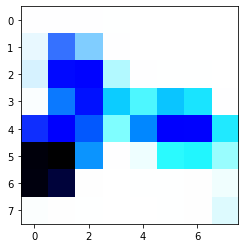

In [27]:
img = model.sample_img().squeeze().permute([1,2,0]).numpy()*255
img = img.astype(np.uint8)
plt.imshow(img)

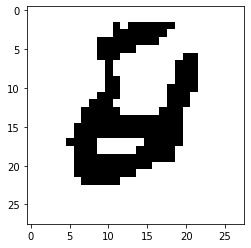

In [10]:
img = 1- (torch.sigmoid(model.sample_img())>0.5).int().squeeze().numpy()
plt.imshow(img, cmap=plt.cm.gray)